In [3]:
import pandas as pd # 0.21.0
import numpy as np
from functools import reduce
from time import time

import os
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import scipy
from scipy import stats
import matplotlib.pyplot as plt

import quandl

In [4]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

### NOTE: 
1. Moving to predict open to close returns, want to avoid gap risk.

In [5]:
import talib as ta
ta.get_function_groups

<function talib.get_function_groups>

In [6]:
np.random.seed(100)
quandl.ApiConfig.api_key = "eFys5fhhsTNVrsJEcQ5y"

In [7]:
df = quandl.get("WIKI/AAPL", start_date="16-01-09", end_date="17-10-17")

In [8]:
df.head(3)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2016-01-11,98.97,99.06,97.3400,98.53,49739377.0,0.0,1.0,95.619735,95.706688,94.044912,95.194629,49739377.0
2016-01-12,100.55,100.69,98.8399,99.96,49154227.0,0.0,1.0,97.146250,97.281511,95.494039,96.576222,49154227.0
2016-01-13,100.32,101.19,97.3000,97.39,62439631.0,0.0,1.0,96.924036,97.764585,94.006267,94.093220,62439631.0


In [9]:
shift = df.shift(1).head(3)
shift.iloc[1] == df.iloc[0]

Open           True
High           True
Low            True
Close          True
Volume         True
Ex-Dividend    True
Split Ratio    True
Adj. Open      True
Adj. High      True
Adj. Low       True
Adj. Close     True
Adj. Volume    True
dtype: bool

In [10]:
def get_features(ticker, start, end):
    try:
        df = quandl.get("WIKI/"+ticker, start_date=start, end_date=end)
    except Exception as e:
        print("Error in getting stock data: {}".format(e))

    # Handle look ahead-bias
    # Only historical data should be available for training.
    shifted_df = df.shift(1)
    
    #log_ret_df = get_close_to_close_log_returns(df['Adj. Close'])
    log_ret_df = get_open_to_close_log_returns(df[['Adj. Close','Adj. Open']])
    
    momentum_df = get_momentum_indicators(shifted_df)
    hist_vol_df = get_hist_vol_indicators(shifted_df)
    pattern_df = get_pattern_recognition_indicators(shifted_df)
    cycle_df = get_cycle_indicators(shifted_df)
    overlap_df = get_overlap_indicators(shifted_df)
    ohlc_df = get_ohlc_features(shifted_df)
    
    dfs = [shifted_df, log_ret_df, momentum_df, hist_vol_df, pattern_df, cycle_df, overlap_df, ohlc_df]
    df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs).dropna()
    return df_final, df

def get_close_to_close_log_returns(df):
    df_log =  pd.DataFrame(np.log(df/df.shift(1))).dropna()
    df_log = df_log.rename(index=str, columns={"Adj. Close": "log_ret"})
    return df_log

def get_open_to_close_log_returns(df):
    df['log_ret'] = np.log(df['Adj. Close']/df['Adj. Open'])
    del df['Adj. Close']
    del df['Adj. Open']
    
    return df

def get_momentum_indicators(df, days = [7,14,28, 56]):
    # http://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html
    df_index = df.index
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    momentum = dict()
    for t in days:
        momentum['adx_{}'.format(t)] = ta.ADX(high, low, close, timeperiod=t)
        momentum['adxr_{}'.format(t)] = ta.ADXR(high, low, close, timeperiod=t)
        momentum['aroondown_{}'.format(t)], momentum['aroonup_{}'.format(t)] = ta.AROON(high, low, timeperiod=t)
        momentum['aroon_{}'.format(t)] = ta.AROONOSC(high, low, timeperiod=t)
        momentum['rsi_{}'.format(t)] = ta.RSI(close, timeperiod=t)
        momentum['mom_{}'.format(t)] = ta.MOM(close, timeperiod=t)
        momentum['roc_{}'.format(t)] = ta.ROC(close, timeperiod=t)
        momentum['willr_{}'.format(t)] = ta.WILLR(high, low, close, timeperiod=t)
        momentum['trix_{}'.format(t)] = ta.TRIX(close, timeperiod=t)
        
        
    momentum['apo'] = ta.APO(close, fastperiod=12, slowperiod=26, matype=0)
    momentum['macd'], momentum['macdsignal'], momentum['macdhist'] = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    momentum['ppo'] = ta.PPO(close, fastperiod=12, slowperiod=26, matype=0)
    momentum['slowk'], momentum['slowd'] = ta.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    momentum['fastk'], momentum['fastd'] = ta.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    momentum['fastkrsi'], momentum['fastdrsi'] = ta.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    
    
    df = pd.DataFrame.from_dict(momentum)
    df = df.set_index(df_index)
    return df

def get_hist_vol_indicators(df, days = [7,14,28, 56]):
    df_index = df.index
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    hist_vol = dict()
    for t in days:
        hist_vol['atr_{}'.format(t)] = ta.ATR(high, low, close, timeperiod=t)
        hist_vol['natr_{}'.format(t)] = ta.NATR(high, low, close, timeperiod=t)
        hist_vol['std_{}'.format(t)] = ta.STDDEV(close, timeperiod=t, nbdev=1)
        hist_vol['var_{}'.format(t)] = ta.VAR(close, timeperiod=t, nbdev=1)
        hist_vol['linreg_{}'.format(t)] = ta.LINEARREG(close, timeperiod=t)

        
    hist_vol['trange'] = ta.TRANGE(high, low, close)
    df = pd.DataFrame.from_dict(hist_vol)
    df = df.set_index(df_index)
    return df

def get_pattern_recognition_indicators(df):
    df_index = df.index
    open = np.array(df['Adj. Open'], dtype='f8') 
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    patterns = dict()
    patterns['CDL2CROWS'] = ta.CDL2CROWS(open, high, low, close)
    patterns['CDL3BLACKCROWS'] = ta.CDL3BLACKCROWS(open, high, low, close)
    patterns['CDL3INSIDE'] = ta.CDL3INSIDE(open, high, low, close)
    patterns['CDL3LINESTRIKE'] = ta.CDL3LINESTRIKE(open, high, low, close)
    patterns['CDL3OUTSIDE'] = ta.CDL3OUTSIDE(open, high, low, close)
    patterns['CDL3STARSINSOUTH'] = ta.CDL3STARSINSOUTH(open, high, low, close)
    patterns['CDL3WHITESOLDIERS'] = ta.CDL3WHITESOLDIERS(open, high, low, close)
    patterns['CDLABANDONEDBABY'] = ta.CDLABANDONEDBABY(open, high, low, close, penetration=0)
    patterns['CDLADVANCEBLOCK'] = ta.CDLADVANCEBLOCK(open, high, low, close)
    patterns['CDLBELTHOLD'] = ta.CDLBELTHOLD(open, high, low, close)
    patterns['CDLBREAKAWAY'] = ta.CDLBREAKAWAY(open, high, low, close)
    patterns['CDLCLOSINGMARUBOZU'] = ta.CDLCLOSINGMARUBOZU(open, high, low, close)
    patterns['CDLCONCEALBABYSWALL'] = ta.CDLCONCEALBABYSWALL(open, high, low, close)
    patterns['CDLCOUNTERATTACK'] = ta.CDLCOUNTERATTACK(open, high, low, close)
    patterns['CDLDARKCLOUDCOVER'] = ta.CDLDARKCLOUDCOVER(open, high, low, close, penetration=0)
    patterns['CDLDOJI'] = ta.CDLDOJI(open, high, low, close)
    patterns['CDLDOJISTAR'] = ta.CDLDOJISTAR(open, high, low, close)
    patterns['CDLDRAGONFLYDOJI'] = ta.CDLDRAGONFLYDOJI(open, high, low, close)
    patterns['CDLENGULFING'] = ta.CDLENGULFING(open, high, low, close)
    patterns['CDLEVENINGDOJISTAR'] = ta.CDLEVENINGDOJISTAR(open, high, low, close, penetration=0)
    patterns['CDLEVENINGSTAR'] = ta.CDLEVENINGSTAR(open, high, low, close, penetration=0)
    patterns['CDLGAPSIDESIDEWHITE'] = ta.CDLGAPSIDESIDEWHITE(open, high, low, close)
    patterns['CDLGRAVESTONEDOJI'] = ta.CDLGRAVESTONEDOJI(open, high, low, close)
    patterns['CDLHAMMER'] = ta.CDLHAMMER(open, high, low, close)
    patterns['CDLHANGINGMAN'] = ta.CDLHANGINGMAN(open, high, low, close)
    patterns['CDLHARAMI'] = ta.CDLHARAMI(open, high, low, close)
    patterns['CDLHARAMICROSS'] = ta.CDLHARAMICROSS(open, high, low, close)
    patterns['CDLHIGHWAVE'] = ta.CDLHIGHWAVE(open, high, low, close)
    patterns['CDLHIKKAKE'] = ta.CDLHIKKAKE(open, high, low, close)
    patterns['CDLHIKKAKEMOD'] = ta.CDLHIKKAKEMOD(open, high, low, close)
    patterns['CDLHOMINGPIGEON'] = ta.CDLHOMINGPIGEON(open, high, low, close)
    patterns['CDLIDENTICAL3CROWS'] = ta.CDLIDENTICAL3CROWS(open, high, low, close)
    patterns['CDLINNECK'] = ta.CDLINNECK(open, high, low, close)
    patterns['CDLINVERTEDHAMMER'] = ta.CDLINVERTEDHAMMER(open, high, low, close)
    patterns['CDLKICKING'] = ta.CDLKICKING(open, high, low, close)
    patterns['CDLKICKINGBYLENGTH'] = ta.CDLKICKINGBYLENGTH(open, high, low, close)
    patterns['CDLLADDERBOTTOM'] = ta.CDLLADDERBOTTOM(open, high, low, close)
    patterns['CDLLONGLEGGEDDOJI'] = ta.CDLLONGLEGGEDDOJI(open, high, low, close)
    patterns['CDLLONGLINE'] = ta.CDLLONGLINE(open, high, low, close)
    patterns['CDLMARUBOZU'] = ta.CDLMARUBOZU(open, high, low, close)
    patterns['CDLMATCHINGLOW'] = ta.CDLMATCHINGLOW(open, high, low, close)
    patterns['CDLMATHOLD'] = ta.CDLMATHOLD(open, high, low, close, penetration=0)
    patterns['CDLMORNINGDOJISTAR'] = ta.CDLMORNINGDOJISTAR(open, high, low, close, penetration=0)
    patterns['CDLMORNINGSTAR'] = ta.CDLMORNINGSTAR(open, high, low, close, penetration=0)
    patterns['CDLONNECK'] = ta.CDLONNECK(open, high, low, close)
    patterns['CDLPIERCING'] = ta.CDLPIERCING(open, high, low, close)
    patterns['CDLRICKSHAWMAN'] = ta.CDLRICKSHAWMAN(open, high, low, close)
    patterns['CDLRISEFALL3METHODS'] = ta.CDLRISEFALL3METHODS(open, high, low, close)
    patterns['CDLSEPARATINGLINE'] = ta.CDLSEPARATINGLINES(open, high, low, close)
    patterns['CDLSHOOTINGSTAR'] = ta.CDLSHOOTINGSTAR(open, high, low, close)
    patterns['CDLSHORTLINE'] = ta.CDLSHORTLINE(open, high, low, close)
    patterns['CDLSPINNINGTOP'] = ta.CDLSPINNINGTOP(open, high, low, close)
    patterns['CDLSTALLEDPATTERN'] = ta.CDLSTALLEDPATTERN(open, high, low, close)
    patterns['CDLSTICKSANDWICH'] = ta.CDLSTICKSANDWICH(open, high, low, close)
    patterns['CDLTAKURI'] = ta.CDLTAKURI(open, high, low, close)
    patterns['CDLTASUKIGAP'] = ta.CDLTASUKIGAP(open, high, low, close)
    patterns['CDLTHRUSTING'] = ta.CDLTHRUSTING(open, high, low, close)
    patterns['CDLTRISTAR'] = ta.CDLTRISTAR(open, high, low, close)
    patterns['CDLUNIQUE3RIVER'] = ta.CDLUNIQUE3RIVER(open, high, low, close)
    patterns['CDLUPSIDEGAP2CROWS'] = ta.CDLUPSIDEGAP2CROWS(open, high, low, close)
    patterns['DLXSIDEGAP3METHODS'] = ta.CDLXSIDEGAP3METHODS(open, high, low, close)
    df = pd.DataFrame.from_dict(patterns)
    df = df.set_index(df_index)
    return df


def get_cycle_indicators(df):
    df_index = df.index
    open = np.array(df['Adj. Open'], dtype='f8') 
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    cycle = dict()
    cycle['HT_DCPERIOD'] = ta.HT_DCPERIOD(close)
    cycle['HT_DCPHASE'] = ta.HT_DCPHASE(close)
    cycle['HT_DCPERIOD'] = ta.HT_DCPERIOD(close)
    cycle['inphase'], cycle['quadrature'] = ta.HT_PHASOR(close)
    cycle['sine'], cycle['leadsine'] = ta.HT_SINE(close)
    cycle['integer'] = ta.HT_TRENDMODE(close)
    
    df = pd.DataFrame.from_dict(cycle)
    df = df.set_index(df_index)
    return df

def get_overlap_indicators(df, days = [7, 14, 28, 56]):
    df_index = df.index
    open = np.array(df['Adj. Open'], dtype='f8') 
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    overlap = dict()
    for t in days:
        bbands = ta.BBANDS(close, timeperiod=t, nbdevup=2, nbdevdn=2, matype=0)
        overlap['bb_upperband_{}'.format(t)], overlap['bb_middleband_{}'.format(t)], overlap['bb_lowerband_{}'.format(t)] = bbands
            
        overlap['DEMA_{}'.format(t)] = ta.DEMA(close, timeperiod=t)
        overlap['EMA_{}'.format(t)] = ta.EMA(close, timeperiod=t)
        
        overlap['KAMA_{}'.format(t)] = ta.KAMA(close, timeperiod=t)
        overlap['MA_{}'.format(t)] = ta.MA(close, timeperiod=t, matype=0)
        overlap['MIDPOINT_{}'.format(t)] = ta.MIDPOINT(close, timeperiod=t)
        overlap['MIDPRICE_{}'.format(t)] = ta.MIDPRICE(high, low, timeperiod=t)
        overlap['SMA_{}'.format(t)] = ta.SMA(close, timeperiod=t)
        overlap['T3_{}'.format(t)] = ta.T3(close, timeperiod=t, vfactor=0)
        overlap['TEMA(_{}'.format(t)] = ta.TEMA(close, timeperiod=t)
        overlap['TRIMA_{}'.format(t)] = ta.TRIMA(close, timeperiod=t)
        overlap['WMA_{}'.format(t)] = ta.WMA(close, timeperiod=t)
        
        
        overlap['HT_TRENDLINE'] = ta.HT_TRENDLINE(close)
        overlap['mama'], overlap['fama'] = ta.MAMA(close, fastlimit=0.9, slowlimit=0.1)
        overlap['SAR'] = ta.SAR(high, low, acceleration=0, maximum=0)
        overlap['SAREXT'] = ta.SAREXT(high, low, startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
    
    df = pd.DataFrame.from_dict(overlap)
    df = df.set_index(df_index)
    return df

def get_ohlc_features(df):
    df_index = df.index
    open = np.array(df['Adj. Open'], dtype='f8') 
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    olhc = dict()
    olhc['hilo_diff'] = high - low
    olhc['opcl_diff'] = close - open
    
    df = pd.DataFrame.from_dict(olhc)
    df = df.set_index(df_index)
    return df
    
    

In [11]:
df, df_orig = get_features("AAPL", "09-01-09", "17-10-17")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
df.head(3)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,...,bb_middleband_56,bb_middleband_7,bb_upperband_14,bb_upperband_28,bb_upperband_56,bb_upperband_7,fama,mama,hilo_diff,opcl_diff
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-05,262.89,263.29,256.75,258.680,25850700.0,0.0,1.0,33.785029,33.836435,32.995953,...,29.726360,33.925844,35.576850,35.284471,35.121029,34.914997,33.579632,33.771089,0.840481,-0.541044
2010-05-06,253.03,258.14,248.73,255.985,31539400.0,0.0,1.0,32.517882,33.174588,31.965272,...,29.853968,33.677720,35.530594,35.253894,35.204408,34.702076,33.312041,32.984985,1.209316,0.379759
2010-05-07,253.83,258.25,199.25,246.250,45923600.0,0.0,1.0,32.620693,33.188724,25.606402,...,29.952304,33.387829,35.553269,35.192517,35.227971,35.140158,33.288996,32.851142,7.582322,-0.974136


In [13]:
print("Any Nans: {}".format(df.isnull().values.any()))
print("Nan count: {}".format(df.isnull().sum().sum()))

Any Nans: False
Nan count: 0


In [14]:
df_orig.loc['2010-05-06']

Open           2.538300e+02
High           2.582500e+02
Low            1.992500e+02
Close          2.462500e+02
Volume         4.592360e+07
Ex-Dividend    0.000000e+00
Split Ratio    1.000000e+00
Adj. Open      3.262069e+01
Adj. High      3.318872e+01
Adj. Low       2.560640e+01
Adj. Close     3.164656e+01
Adj. Volume    3.214652e+08
Name: 2010-05-06 00:00:00, dtype: float64

In [15]:
del df['Open']
del df['High']
del df['Low']
del df['Close']
del df['Ex-Dividend']
del df['Split Ratio']



In [16]:
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = df[numerical_features]
train_cat = df[categorical_features]

Numerical features : 210
Categorical features : 0


### Date, Time features

In [17]:
df['Date'] = df.index
#df[['year','month','day']] = df.Date.str.split('-',expand=True)
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_56,...,bb_upperband_28,bb_upperband_56,bb_upperband_7,fama,mama,hilo_diff,opcl_diff,Date,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-05,25850700.0,33.785029,33.836435,32.995953,33.243985,180954900.0,0.011611,45.136260,29.777463,18.923556,...,35.284471,35.121029,34.914997,33.579632,33.771089,0.840481,-0.541044,2010-05-05,5,5
2010-05-06,31539400.0,32.517882,33.174588,31.965272,32.897640,220775800.0,-0.030317,42.009384,29.185824,18.886902,...,35.253894,35.204408,34.702076,33.312041,32.984985,1.209316,0.379759,2010-05-06,5,6
2010-05-07,45923600.0,32.620693,33.188724,25.606402,31.646557,321465200.0,-0.032741,42.763943,29.243772,18.802612,...,35.192517,35.227971,35.140158,33.288996,32.851142,7.582322,-0.974136,2010-05-07,5,7


In [18]:
del df['Date']
df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_56,...,bb_upperband_14,bb_upperband_28,bb_upperband_56,bb_upperband_7,fama,mama,hilo_diff,opcl_diff,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-05,25850700.0,33.785029,33.836435,32.995953,33.243985,180954900.0,0.011611,45.136260,29.777463,18.923556,...,35.576850,35.284471,35.121029,34.914997,33.579632,33.771089,0.840481,-0.541044,5,5
2010-05-06,31539400.0,32.517882,33.174588,31.965272,32.897640,220775800.0,-0.030317,42.009384,29.185824,18.886902,...,35.530594,35.253894,35.204408,34.702076,33.312041,32.984985,1.209316,0.379759,5,6
2010-05-07,45923600.0,32.620693,33.188724,25.606402,31.646557,321465200.0,-0.032741,42.763943,29.243772,18.802612,...,35.553269,35.192517,35.227971,35.140158,33.288996,32.851142,7.582322,-0.974136,5,7


### Create lagged features

In [19]:
steps = 20
lags_df = (pd.concat(
    [df.log_ret.shift(i) for i in range(steps)],
    axis=1,
    keys=['log_ret'] + ['log_ret_L%s' % i for i in range(1, steps)]
).dropna()
)
# To ensure that only past frames are used to predict
# (e.g to predict target at t, we use t-1,t-2, etc.)
lags_df = lags_df.drop(['log_ret'], axis=1)
final_df = pd.merge(df, lags_df, left_index=True, right_index=True)

In [20]:

final_df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_56,...,log_ret_L10,log_ret_L11,log_ret_L12,log_ret_L13,log_ret_L14,log_ret_L15,log_ret_L16,log_ret_L17,log_ret_L18,log_ret_L19
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-02,31302600.0,33.373784,34.176997,33.279969,33.520290,219118200.0,-0.002233,35.027386,25.911122,16.738082,...,-0.018142,-0.001886,-0.005285,-0.018636,0.010914,0.018413,0.014834,-0.032741,-0.030317,0.011611
2010-06-03,24591000.0,33.997077,34.030491,33.456676,33.921254,172137000.0,-0.007799,33.270956,25.407941,16.559237,...,-0.004660,-0.018142,-0.001886,-0.005285,-0.018636,0.010914,0.018413,0.014834,-0.032741,-0.030317
2010-06-04,23218100.0,34.079326,34.126876,33.466315,33.814587,162526700.0,-0.008732,31.553821,24.898773,16.376580,...,-0.017180,-0.004660,-0.018142,-0.001886,-0.005285,-0.018636,0.010914,0.018413,0.014834,-0.032741


In [21]:
print("Any Nans: {}".format(final_df.isnull().values.any()))
print("Nan count: {}".format(final_df.isnull().sum().sum()))

Any Nans: False
Nan count: 0


In [22]:
# Classify data.
# Up (1) if greater than 1%, (0) nuetral, (2)down if less than -1%

final_df["y"] = final_df.apply(
    lambda x: 1 if ((np.exp(x['log_ret']) - 1) > 0.005) else 2 if (np.exp(x['log_ret']) - 1) < -0.005 else 0 ,
    axis=1
)


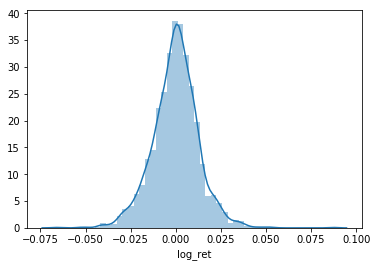

In [23]:
import seaborn as sns
%matplotlib inline
sns.distplot(np.exp(final_df['log_ret'])-1)

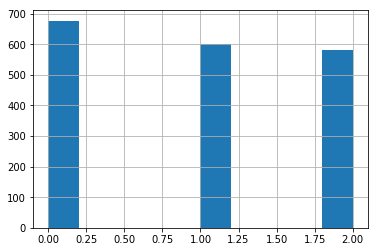

In [24]:
# Labels after bucketing are a bit more uniformly distributed.
final_df['y'].hist()

In [25]:
# Remove log_ret which can lead to look ahead effects
del final_df["log_ret"]

In [26]:
print("shape: {}".format(final_df.shape))


shape: (1858, 231)


In [27]:
train_size = int(final_df.shape[0]*0.9)

### Split into train and test

In [28]:
train, test = final_df.iloc[:train_size], final_df.iloc[train_size:]
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (1672, 231)
Test shape: (186, 231)


In [29]:
train.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,adx_14,adx_28,adx_56,adx_7,...,log_ret_L11,log_ret_L12,log_ret_L13,log_ret_L14,log_ret_L15,log_ret_L16,log_ret_L17,log_ret_L18,log_ret_L19,y
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-02,31302600.0,33.373784,34.176997,33.279969,33.520290,219118200.0,35.027386,25.911122,16.738082,33.266021,...,-0.001886,-0.005285,-0.018636,0.010914,0.018413,0.014834,-0.032741,-0.030317,0.011611,0
2010-06-03,24591000.0,33.997077,34.030491,33.456676,33.921254,172137000.0,33.270956,25.407941,16.559237,29.872039,...,-0.018142,-0.001886,-0.005285,-0.018636,0.010914,0.018413,0.014834,-0.032741,-0.030317,2
2010-06-04,23218100.0,34.079326,34.126876,33.466315,33.814587,162526700.0,31.553821,24.898773,16.376580,27.283272,...,-0.004660,-0.018142,-0.001886,-0.005285,-0.018636,0.010914,0.018413,0.014834,-0.032741,2


In [38]:
train.to_csv('train_data_oc.csv', index=False) # If exporting for use in training 'train.py' in aws set index = False
test.to_csv('test_data_oc.csv', index=False)
train_dummy = pd.read_csv('train_data_oc.csv')
test_dummy = pd.read_csv('test_data_oc.csv')
train_dummy = train_dummy.set_index('Date')
test_dummy = test_dummy.set_index('Date')

KeyError: 'Date'

In [39]:
train_dummy.head(3).T

,0,1,2
Volume,3.130260e+07,2.459100e+07,2.321810e+07
Adj. Open,3.337378e+01,3.399708e+01,3.407933e+01
Adj. High,3.417700e+01,3.403049e+01,3.412688e+01
Adj. Low,3.327997e+01,3.345668e+01,3.346631e+01
Adj. Close,3.352029e+01,3.392125e+01,3.381459e+01
Adj. Volume,2.191182e+08,1.721370e+08,1.625267e+08
adx_14,3.502739e+01,3.327096e+01,3.155382e+01
adx_28,2.591112e+01,2.540794e+01,2.489877e+01
adx_56,1.673808e+01,1.655924e+01,1.637658e+01
adx_7,3.326602e+01,2.987204e+01,2.728327e+01


### Assess distribution and statistics of data

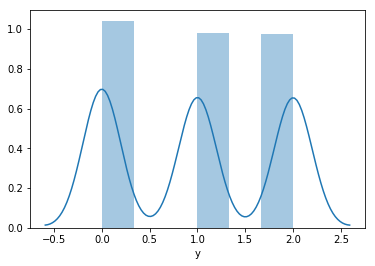

In [32]:
train_y_dummy = train_dummy.pop('y')
test_y_dummy = test_dummy.pop('y')

import seaborn as sns
%matplotlib inline
sns.distplot(train_y_dummy)

In [33]:
test_y_dummy = pd.DataFrame(test_y_dummy).set_index(test_dummy.index)
test_y_dummy.head()

,y
Date,
2017-01-23,0
2017-01-24,0
2017-01-25,1
2017-01-26,0
2017-01-27,0


### Train RandomForest classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline

rfc = RandomForestClassifier()
rfc_model = rfc.fit(train_dummy, train_y_dummy)
rfc_pred = rfc_model.predict(test_dummy)
print("Accuracy for Random Forest Model: %.2f" % (accuracy_score(test_y_dummy, rfc_pred) * 100))



Accuracy for Random Forest Model: 37.63


In [35]:
print(train_dummy.shape)
print(train_y_dummy.shape)

(1672, 230)
(1672,)


In [36]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_xgb = {
    'clf__max_depth': range(3,10,2),
    'clf__min_child_weight': range(1,6,2)
}

pipe_xgb = Pipeline([('clf', xgb.XGBClassifier())])

grid = GridSearchCV(pipe_xgb, param_grid=param_xgb)
grid.fit(train_dummy,  train_y_dummy)

print("The best parameters are {} with a score of {:0.5f}".format(
    grid.best_params_, grid.best_score_)
)

xgbc.fit(train_dummy,  train_y_dummy)
pred = xgbc.predict(test_dummy)
print("Accuracy for XGB Model: %.2f" % (accuracy_score(test_y_dummy, pred) * 100))


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/d

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

The best parameters are {'clf__min_child_weight': 3, 'clf__max_depth': 7} with a score of 0.35347


NameError: name 'xgbc' is not defined

In [37]:
xgbc = xgb.XGBClassifier(max_depth=7, min_child_weight=3)
xgbc.fit(train_dummy,  train_y_dummy)
pred = xgbc.predict(test_dummy)
print("Accuracy for XGB Model: %.2f" % (accuracy_score(test_y_dummy, pred) * 100))


Accuracy for XGB Model: 30.11


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [281]:
pred = pd.DataFrame(pred)
pred = pred.rename(columns={0:'y'})
pred = pred.set_index(test_y_dummy.index)
pred.head()

,y
Date,
2017-01-23,1
2017-01-24,0
2017-01-25,0
2017-01-26,0
2017-01-27,0


In [282]:
df_backtest = df_orig.loc['2017-01-23':]
df_backtest.head(3)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2017-01-23,120.00,120.81,119.77,120.08,22050218.0,0.0,1.0,118.517825,119.317820,118.290666,118.596837,22050218.0
2017-01-24,119.55,120.10,119.50,119.97,23211038.0,0.0,1.0,118.073383,118.616590,118.024000,118.488195,23211038.0
2017-01-25,120.42,122.10,120.28,121.88,32586673.0,0.0,1.0,118.932637,120.591887,118.794366,120.374604,32586673.0


In [283]:
df_backtest = df_backtest.join(pred)
df_backtest.head(3)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,y
Date,,,,,,,,,,,,,
2017-01-23,120.00,120.81,119.77,120.08,22050218.0,0.0,1.0,118.517825,119.317820,118.290666,118.596837,22050218.0,1
2017-01-24,119.55,120.10,119.50,119.97,23211038.0,0.0,1.0,118.073383,118.616590,118.024000,118.488195,23211038.0,0
2017-01-25,120.42,122.10,120.28,121.88,32586673.0,0.0,1.0,118.932637,120.591887,118.794366,120.374604,32586673.0,0


In [284]:
def get_strategy_returns(x):
    if x['y'] == 1:
        return np.log(x['Adj. Close']/x['Adj. Open'])
    elif x['y'] == 2:
        return np.log(x['Adj. Open']/x['Adj. Close'])
    else:
        return 0
    

df_backtest['RETURN'] = df_backtest.apply(get_strategy_returns , axis=1)
df_backtest['CUM_RETURN'] = df_backtest.RETURN.cumsum()

In [285]:
df_backtest['CUM_RETURN_EQUITY']=((df_backtest.CUM_RETURN+1)*100)

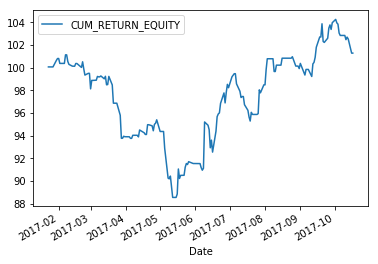

In [287]:
df_backtest[['CUM_RETURN_EQUITY']].plot()